**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

# Data Preparation

In [2]:
class_name = 'Occupancy'
df = pd.read_csv('occupancy_data/datatraining.txt', skipinitialspace=True, na_values='?', keep_default_na=True)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
def daytime(h):
    if 6 <= h < 13:
        return 'morning'
    elif 13 <= h < 18:
        return 'afternoon'
    elif 18 <= h < 22:
        return 'evening'
    return 'night'

In [6]:
from data_preparation import prepare_dataset

ImportError: cannot import name 'prepare_dataset' from 'dataprep' (/home/dm2/anaconda3/lib/python3.8/site-packages/dataprep/__init__.py)

In [12]:
df['daytime'] = [daytime(d.hour) for d in pd.to_datetime(df['date'])]
df['weekend'] = [1 if d.weekday() >= 5 else 0 for d in pd.to_datetime(df['date'])]
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)
df0 = df.copy()
dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
dfY = df[class_name]
df = pd.concat([dfX, dfY], axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,weekend,daytime=afternoon,daytime=evening,daytime=morning,daytime=night,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,0,1,0,0,0,1
2,23.15,27.2675,429.5,714.00,0.004783,0,1,0,0,0,1
3,23.15,27.2450,426.0,713.50,0.004779,0,1,0,0,0,1
4,23.15,27.2000,426.0,708.25,0.004772,0,1,0,0,0,1
5,23.10,27.2000,426.0,704.50,0.004757,0,1,0,0,0,1


In [14]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [15]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Box Plot

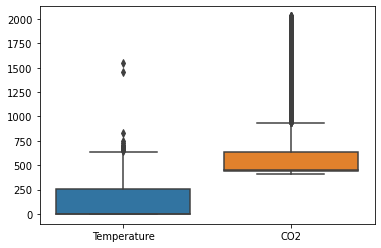

In [16]:
sns.boxplot(data=[X[:,2], X[:,3]])
plt.xticks([0,1], [attributes[0], attributes[3]])
plt.show()

# DBSCAN

In [17]:
from sklearn.cluster import DBSCAN

In [18]:
dbscan = DBSCAN(eps=100, min_samples=4)
dbscan.fit(X)

DBSCAN(eps=100, min_samples=4)

In [19]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([   8, 8135]))

In [20]:
df0.loc[np.where(dbscan.labels_==-1)]

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,daytime,weekend
1453,22.075000,23.972500,426.000000,839.000000,0.003934,1,evening,0
2606,21.290000,19.666667,131.333333,665.333333,0.003072,0,afternoon,0
3830,20.700000,18.917500,215.000000,454.500000,0.002849,0,morning,1
3831,20.700000,18.890000,611.500000,452.250000,0.002845,0,morning,1
3832,20.700000,18.890000,1546.333333,455.333333,0.002845,0,morning,1
3833,20.745000,18.890000,1451.750000,453.000000,0.002853,0,morning,1
6943,21.200000,32.790000,13.000000,1115.500000,0.005111,0,afternoon,0
7213,22.066667,37.760000,423.666667,1796.666667,0.006217,1,evening,0


# LOF

In [21]:
from sklearn.neighbors import LocalOutlierFactor

In [22]:
clf = LocalOutlierFactor(n_neighbors=2)
outliers = clf.fit_predict(X)

negative_outlier_factor_

The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.

The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. It is the average of the ratio of the local reachability density of a sample and those of its k-nearest neighbors.

In [23]:
clf.negative_outlier_factor_

array([-1.17343898, -0.96797813, -0.96797813, ..., -1.11985692,
       -0.97866925, -1.41555562])

In [24]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([1609, 6534]))

In [25]:
np.where(outliers==-1)

(array([   4,   16,   20, ..., 8119, 8126, 8132]),)

In [26]:
clf.negative_outlier_factor_[np.where(outliers==-1)]

array([-1.87162857, -4.93312113, -2.71673209, ..., -2.30524357,
       -1.57811723, -1.60492897])

In [27]:
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.5000000236592839

In [28]:
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)])

-14159978816.08588

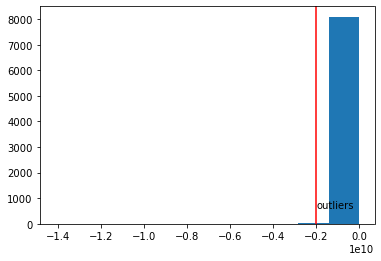

In [29]:
plt.hist(clf.negative_outlier_factor_, bins=10)
plt.axvline(-0.2*1e10, c='r')
plt.text(-0.2*1e10, 600, 'outliers')
plt.show()

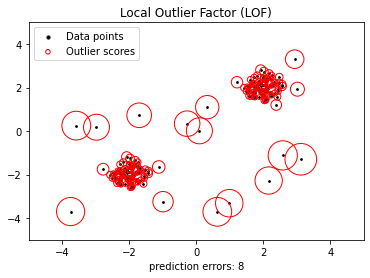

In [30]:
np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
Xa = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(Xa), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(Xa)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(Xa[:, 0], Xa[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(Xa[:, 0], Xa[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [31]:
from sklearn.ensemble import IsolationForest

In [32]:
clf = IsolationForest(random_state=0)
clf.fit(X_train)

IsolationForest(random_state=0)

In [33]:
outliers = clf.predict(X_test)

In [34]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([1201, 1242]))

# PyOD

https://pyod.readthedocs.io/en/latest/#

In [36]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.auto_encoder import AutoEncoder

## ABOD

In [37]:
clf = ABOD()
clf.fit(X)

/home/dm2/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dm2/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/dm2/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [38]:
clf.decision_scores_

array([-7.41625258e-05, -1.90111501e-04, -2.00510917e-04, ...,
       -1.25669744e-05, -1.89693499e-05, -2.46130124e-06])

In [39]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

/home/dm2/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dm2/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/dm2/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([0]), array([8143]))

ValueError: zero-size array to reduction operation minimum which has no identity

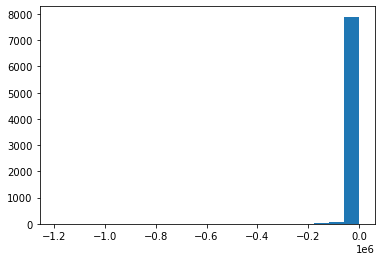

In [40]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

## KNN

In [41]:
clf = KNN()
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [42]:
clf.decision_scores_

array([11.44577584,  9.09074294,  9.12458908, ..., 14.99998433,
       14.01599245, 15.99986567])

In [43]:
anomlay_score = clf.decision_function(X)

In [44]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([7502,  641]))

In [45]:
np.mean(anomlay_score[np.where(outliers==1)])

20.775031602552552

In [46]:
np.mean(anomlay_score[np.where(outliers==0)])

2.0124189044276126

In [47]:
np.mean(clf.decision_scores_[np.where(outliers==1)])

22.693769518236714

In [48]:
np.mean(clf.decision_scores_[np.where(outliers==0)])

2.3663837647022388

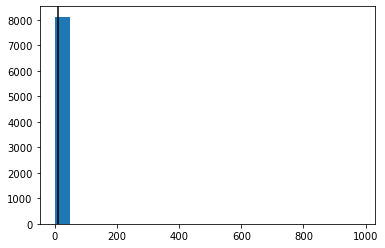

In [49]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

## LOF

In [50]:
clf = LOF()
clf.fit(X)

outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([7412,  731]))

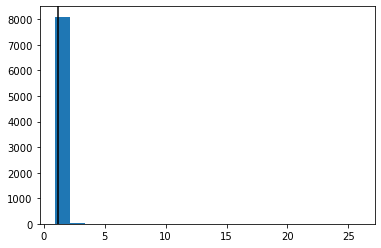

In [51]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# AutoEncoder

In [56]:
clf = AutoEncoder(epochs=10)

In [57]:
clf.fit(X)

outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

ValueError: The number of neurons should not exceed the number of features

In [58]:
anomlay_score = clf.decision_function(X)

NotFittedError: This AutoEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
outliers_proba = clf.predict_proba(X)

In [ ]:
plt.hist(outliers_proba, bins=20)
#plt.axvline(np.min(anomlay_score[np.where(outliers==1)]), c='k')
plt.show()

In [ ]:
plt.hist(anomlay_score, bins=20)
plt.axvline(np.min(anomlay_score[np.where(outliers==1)]), c='k')
plt.show()

In [59]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


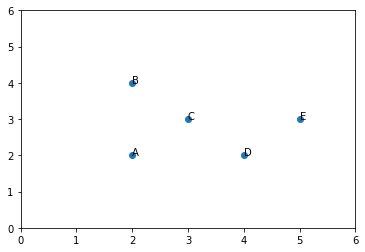

In [61]:
D = np.array([
    [2, 2],
    [2, 4],
    [3, 3],
    [4, 2],
    [5, 3],
])


plt.scatter(D[:, 0], D[:, 1])
for d, l in zip(D, ['A', 'B', 'C', 'D', 'E']):
    plt.text(d[0], d[1], l)
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.show()

In [62]:
from scipy.spatial.distance import pdist, squareform

In [63]:
dist = squareform(pdist(D, 'cityblock'))
for i in range(len(dist)):
    dist[i, i] = np.inf
dist

array([[inf,  2.,  2.,  2.,  4.],
       [ 2., inf,  2.,  4.,  4.],
       [ 2.,  2., inf,  2.,  2.],
       [ 2.,  4.,  2., inf,  2.],
       [ 4.,  4.,  2.,  2., inf]])

In [64]:
k = 3
knn = np.argsort(dist, axis=1)[:, :k]
knn

array([[1, 2, 3],
       [0, 2, 3],
       [0, 1, 3],
       [0, 2, 4],
       [2, 3, 0]])

In [65]:
Rknn = np.zeros((len(dist), len(dist)))
for i in range(len(dist)):
    for j in knn[i]:
        Rknn[j][i] = 1
Rknn

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [66]:
Rknn_count = np.sum(Rknn, axis=1)
Rknn_count.reshape(-1,1)

array([[4.],
       [2.],
       [4.],
       [4.],
       [1.]])

# Grubbs Test

In [67]:
# https://pypi.org/project/outlier_utils/

In [68]:
import numpy as np
from scipy import stats

In [69]:
data = np.array([100, 5, 14, 15, 15, 14, 19, 17, 16, 20, 22, 8, 21, 28, 11, 9, 50])

In [70]:
alpha = 0.95

In [71]:
n = len(data)

In [72]:
n

17

In [73]:
significance_level = alpha / (2*n)  #alpha / n

In [74]:
significance_level

0.027941176470588233

In [75]:
t = stats.t.isf(significance_level, n-2)

In [76]:
t

2.07234981714787

In [77]:
g_test = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))

In [78]:
g_test

1.8307975361987219

In [79]:
relative_values = abs(data - data.mean())
index = relative_values.argmax()
value = relative_values[index]

In [80]:
g = value / data.std()

In [81]:
g, g_test

(3.574292659277283, 1.8307975361987219)

In [82]:
if g > g_test:
    print('outlier')
else:
    print('inlier')

outlier


In [83]:
stats.t.isf(0.01, 10)

2.7637694574478893

In [84]:
stats.t.isf(0.01, 100)

2.364217365904738

In [85]:
stats.t.isf(0.01, 1000)

2.33008267475551

In [86]:
stats.t.isf(0.001, 10)

4.143700494046624

In [87]:
stats.t.isf(0.001, 10)

4.143700494046624

In [88]:
stats.t.isf(0.001, 100)

3.1737394889844106

In [89]:
stats.t.isf(0.001, 1000)

3.098402163912876

In [90]:
stats.t.isf(0.01, 100, 2)

4.364217365904738

# Likelihood Appraoch

In [91]:
import numpy as np
from scipy import stats

In [92]:
data = np.array([100, 5, 14, 15, 15, 14, 19, 17, 16, 20, 22, 8, 21, 28, 11, 9, 50])

In [93]:
def norm_dist(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.e**(-((x-mu)**2)/(2*sigma**2))
              
def unif_dist(x, n):
    return 1/n

In [94]:
M = np.copy(data)
A = list()
muM = np.mean(M)
sigmaM = np.std(M)

In [95]:
norm_dist(15, muM, sigmaM)

0.017323544875621277

In [96]:
M = np.copy(data)
A = list()
lambda_par = 0.3

muM = np.mean(M)
sigmaM = np.std(M)
sizeA = len(A)
sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])
sumA = np.sum([unif_dist(x, sizeA) for x in A])
ll = -(len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)

In [97]:
M = np.copy(data)
A = list()
c = 0.2
for i, x in enumerate(data):
    A.append(x)
    M = np.array([xo for j, xo in enumerate(data) if i!=j])
    muM = np.mean(M)
    sigmaM = np.std(M)
    sizeA = len(A)
    sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])
    sumA = np.sum([unif_dist(x, sizeA) for x in A])
    ll_xi = - (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)
    delta_ll = ll - ll_xi
    print(i, delta_ll, 'outlier' if delta_ll > c else 'inlier')
    M = np.copy(data)
    A = list()

0 0.3977128481343115 outlier
1 0.13457765542953126 inlier
2 0.12934931124330795 inlier
3 0.1290276899776579 inlier
4 0.1290276899776579 inlier
5 0.12934931124330795 inlier
6 0.12833240056265893 inlier
7 0.1285594628732225 inlier
8 0.12876398097943031 inlier
9 0.12831168680625638 inlier
10 0.12845932478202648 inlier
11 0.13240735661756986 inlier
12 0.12835381788710265 inlier
13 0.13043326305691316 inlier
14 0.13064686254892344 inlier
15 0.13177222116900822 inlier
16 0.15497943889092447 inlier
